# Lecture 3, Nonlinear dynamics, stability and bifurcations

> ordinary differential equations (ODE)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import HTML
from IPython.display import display

from scipy.integrate import solve_ivp

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output


In [2]:
import warnings
warnings.filterwarnings("ignore")

In our last session, we analyzed how the Earth's temperature changed over time, utilizing a simplistic yet surprisingly effective model. Today, we'll build on that foundation, looking at stability.

Our simple model is based on *ordinary differential equations (ODEs)*, where some variables change in time - with the rate of change as a function of their current values.


$$ \frac{dx(t)}{dt} = f(x(t)) $$

The simplest numerical method to solve such an equation is the **(forward) Euler method**, in which we convert this equation into an explicit time-stepping routine:

$$ \frac{dx(t)}{dt} = \frac{x(t+\Delta t) - x(t)}{\Delta t}$$

```{prf:assumption}
:label: euler-forward

$$ x(t+\Delta t) \simeq x(t) + \Delta t f(x(t)) $$
```

## Solving the ODE: Euler method

Let's use this to simulate a simple nonlinear ODE that describes the dynamics of a population of bacteria. The bacteria will grow by reproduction at a rate $\lambda$ when sufficient food is available, in which case we would have $\dot{x} = \lambda x$. However, the available food limits the sustainable population to a value of $K$, leading to a modified equation:

$$\dot{x} = \lambda \, x \, (K - x).$$

In this model, when $x$ is close to 0, the growth rate is close to zero and it increases as $x$ increases, reaching a maximum when $x$ is at half of the carrying capacity ($K/2$). Beyond this point as $x$ continues to increase, the growth rate starts to decrease, eventually approaching zero as x gets closer to $K$

This is sometimes called the [**logistic** differential equation](https://en.wikipedia.org/wiki/Logistic_function#Logistic_differential_equation) (although the name does not seem particularly helpful).

Our goal is to use computational thinking, but we will only be interested in the exact dynamics in time rather than in the **qualitative** features of the system's behavior. For example, at long times (formally $t \to \infty$), does the population get arbitrarily large? Or does it, for example, oscillate around a particular value? Or does it converge to a particular size?

This forms the subject of **nonlinear dynamics** or **dynamical systems** theory. 

Let's simulate the system using the Euler method to try to guess the answer to this question. We should never use the Euler method in practice. Instead, we should use a tested library (` scipy.integrate import odeint`) that provides much better accuracy in the solutions if we are interested in faithful numerical results.


```{exercise} 
Implement the forward Euler method as given in {prf:ref}`euler-forward`

Change the growth rate and see how the model responds. Describe the behavior.
```

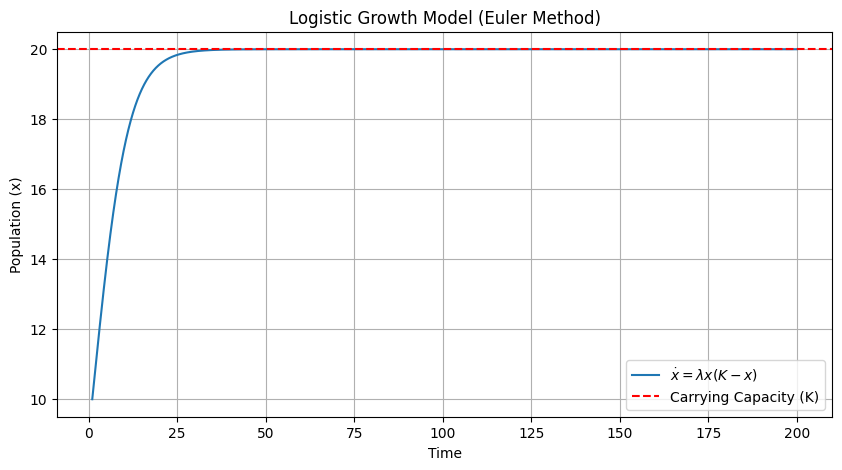

In [3]:
lambda_ = 0.01  # Growth rate
K = 20          # Carrying capacity
x0 = 10         # Initial population

t = np.linspace(1, 200, 10000)
dt = t[1] - t[0]  # Time step

x = np.zeros_like(t)

x[0] = x0

for i in range(1, len(t)):
    x[i] = x[i-1] + dt * lambda_ * x[i-1] * (K - x[i-1])

plt.figure(figsize=(10, 5))
plt.plot(t, x, label=r'$\dot{x} = \lambda x (K - x)$')
plt.xlabel('Time')
plt.ylabel('Population (x)')
plt.title('Logistic Growth Model (Euler Method)')
plt.axhline(y=K, color='r', linestyle='--', label='Carrying Capacity (K)')
plt.legend()
plt.grid(True)

In the following, we will rescale the function to its simplest form

$$ \frac{dx}{dx} = x(1-x) $$

In [4]:
def logistic(initial_population, timesteps):
    """
    Computes the logistic growth of a population over given timesteps.
    
    Parameters:
        initial_population (float or array-like): The initial population or an array of population values.
        timesteps (array-like): An array of time steps at which to compute the population values.
        
    Returns:
        numpy.ndarray: An array of population values at the given timesteps.
    """
    population = np.asarray(initial_population, dtype=float)
    time_differences = np.diff(timesteps)
    
    for time_step in time_differences:
        if population.size == 1:
            next_population = population + time_step * population * (1 - population)
        else:
            next_population = population[-1] + time_step * population[-1] * (1 - population[-1])
        population = np.append(population, next_population)
        
    return population


In [5]:
t1 = np.arange(0,20, 0.01)
dxdt = logistic(0.5, t1)

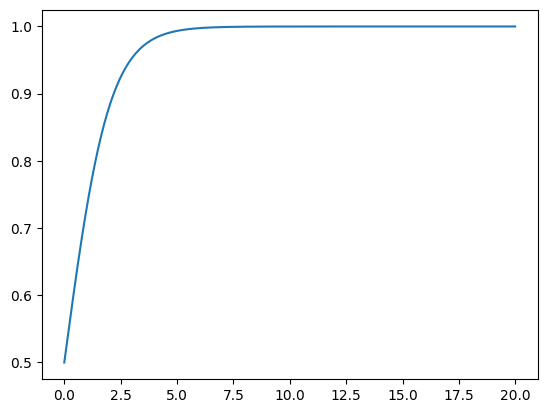

In [6]:
plt.plot(t1, dxdt)

```{important}
We see that for this particular initial condition, the solution seems to settle down to a fixed value after some time, and then remains at that value thereafter.

Such a value is called a **fixed point** or a **stationary point** of the ODE.
```

## Qualitative behaviour: Fixed points and their stability

But what happens if we have a different initial condition:

In [7]:
def plot_func(initial_condition):
    plt.close("all")
    plt.figure(figsize=(10, 6))
    plt.plot(t1, logistic(initial_condition, t1), linewidth=2, color='#1f77b4')
    plt.title('Dynamics of Bacterial Population Growth', fontsize=16)
    plt.xlabel('Time ($t$)', fontsize=14, labelpad=10)
    plt.ylabel('Population ($x(t)$)', fontsize=14, labelpad=10)
    
    plt.xlim([0, 10])
    plt.ylim(-3, 3)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()
    
interact(plot_func, initial_condition=widgets.FloatSlider(value=0.5, min=-3, max=3, step=0.1, description='Initial Condition:', style={'description_width': 'initial'}))

interactive(children=(FloatSlider(value=0.5, description='Initial Condition:', max=3.0, min=-3.0, style=Slider…

<function __main__.plot_func(initial_condition)>

To get an overview, we can draw all graphs in a single plot.

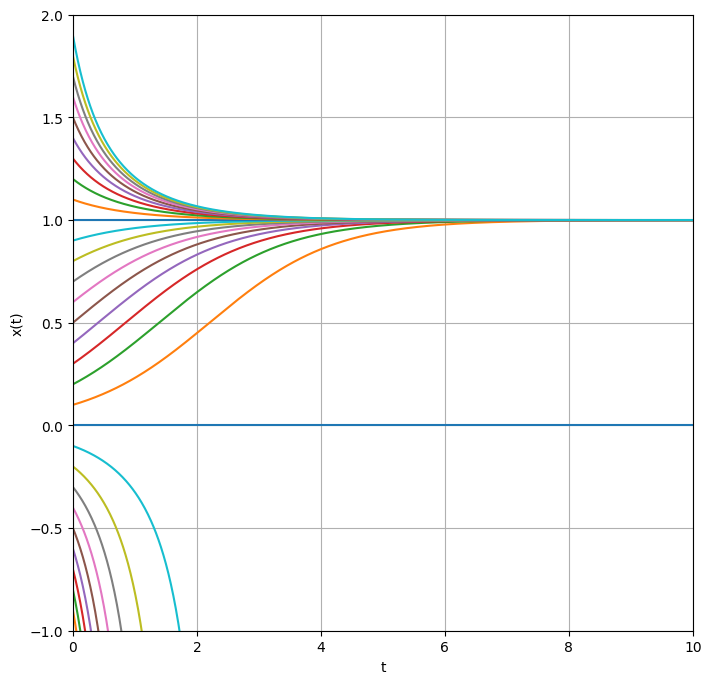

In [8]:
plt.figure(figsize=(8,8))
for initial_condition in np.arange(-1, 2, 0.1):
    plt.plot(t1, logistic(initial_condition, t1))
plt.xlabel("t")
plt.ylabel("x(t)")
plt.xlim([0,10])
plt.ylim(-1, 2)
plt.grid()
plt.show()

We observe that trajectories initiating near $x_0=1.0$ appear to converge to 1 as time progresses. In the particular case where the system starts *precisely* at 0, it remains there indefinitely. Conversely, for starting points in close proximity to 0, on either side, the trajectory diverges *away* from 0, maintaining its side of origin. In scenarios where the initial value is negative, $x$ becomes increasingly negative over time. Although negative populations contradict the original interpretation as population dynamics, exploring the dynamics of the equation with negative initial conditions remains valid, as it may represent other systems.

The distinguished values $x^*_1=1$ and $x^*_2=0$ are termed **stationary points** or **fixed points** of the differential equation. Starting at $x^*_i$, the derivative evaluates to $f'(x^*_i) = 0$, rendering any movement away from $x^*_i$ impossible! We can locate the fixed points by identifying the zeros or **roots** of the function $f$, defined as values $x^*$ such that $f'(x^*) = 0$.

However, we discern a **qualitative difference** between the two types of fixed points: trajectories near $x^*_1 = 1$ gravitate *towards* $x^*_1$, while those near $x^*_2 = 0$ repel *away* from it. Consequently, $x^*_1$ is classified as a **stable fixed point**, and $x^*_2$ as an **unstable fixed point**.

Finding analytical expressions for the position and stability of fixed points is generally infeasible; alternatively, numerical **root-finding algorithms**, such as the Newton method, can be employed.

## State space: Vector field and phase portrait

If we want to find the whole trajectory for a given initial condition, then we need to solve the equations, either numerically or analytically.

However, we may want less information about the system, for example, the **long-time** or **asymptotic** dynamics. It turns out that we can obtain some information about that *without* explicitly solving the ODE! This is the **qualitative approach** to studying nonlinear systems.

Instead of drawing trajectories $x(t)$ as a function of time $t$, as we did above, let's use a different graphical representation, where we draw **state space** or **phase space**: This is the set ("space") of all possible values of the dependent variables ("states"). For the above ODE, there is only a single dependent variable, $x$, so the state space is the real line, $\mathbb{R}$.

At each possible value of $x$, the ODE gives us information about the rate of change of $x(t)$ at that point. Let's draw an **arrow** at that point, pointing in the direction that a particle placed at that point would move: to the right if $\dot{x} > 0$ and to the left if $\dot{x} < 0$.

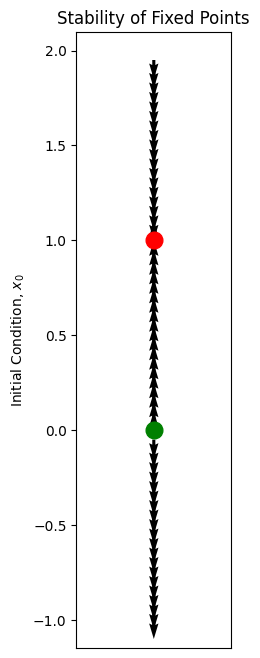

In [9]:
states = np.array([])
initial_conditions = np.arange(-1, 2, 0.05)

for initial_condition in initial_conditions:
    states = np.append(states, logistic(initial_condition, t1)[-1])

X = np.ones(len(states))
Y = initial_conditions.copy()
U = np.zeros(len(states))
V = np.ones(len(states))
V[states - initial_conditions < 0] = -1

states[states == -np.inf] = 2

# Create the quiver plot
plt.figure(figsize=(2,8))
plt.quiver(X, Y, U, V, scale=10, width=0.02, angles='xy', scale_units='xy')

# Mark the fixed points
plt.plot([1, 1], 'ro', markersize=12)
plt.plot([1, 0], 'go', markersize=12)
# Set plot limits and remove x-axis labels
plt.xlim([1, 1])
plt.xticks([])

# Add labels
plt.ylabel('Initial Condition, $x_0$')
plt.title('Stability of Fixed Points')

# Show the plot
plt.show()

`````{admonition} Dynamics of the system
:class: tip

This vector field indeed gives us a *qualitative* picture of the dynamics. It does not tell us how **fast** the dynamics will occur in each region, but it indicates what the **tendency** is.

We have coded the fixed points according to their stability; this may be calculated using the derivative evaluated at the fixed point, $f'(x^*)$, since this derivative controls the behaviour of nearby initial conditions $x^* + \delta x$.

`````

## Bifurcations

Now, suppose that there is a **parameter** $\mu$ in the system that can be varied. For each value of $\mu$ we have a *different* ODE

$$\dot{x} = f_\mu(x).$$
For example, 
$$\dot{x} = \mu + x^2.$$
Let's draw the state space for each different value of $\mu$:

In [11]:
def xdot(mu, x):
    return mu + x**2

t = np.arange(-5, 5, 0.001)

def plot_func(initial_condition):
    plt.figure(figsize=(8,8))
    a = xdot(mu = initial_condition, x = t)
    plt.plot(t, a)
    plt.title("Dynamics of the system described by  $x^{'}(t) = μ + x^2$", fontsize=14)

    plt.xlabel("t")
    plt.ylabel("x'(t)")
    plt.xlim([-5,5])
    plt.ylim(-2, 2)
    plt.grid()
    
    try:
        zero_crossings = np.where(np.diff(np.signbit(a)))[0]
        plt.text(t[zero_crossings[0]]+0.2, 1.8, "Zero Crossing", rotation=0, fontsize=10, color='green')
        plt.text(t[zero_crossings[1]]+0.2, 1.8, "Zero Crossing", rotation=0, fontsize=10, color='green')
        plt.vlines(t[zero_crossings+1], ymin=-2,ymax=2, ls = "--", color = "black")
        for arrows in np.arange(-5,t[zero_crossings[0]],0.5):
            plt.arrow(arrows, 0, 0.25, 0,shape='full', lw=1, length_includes_head=True, head_width=.05, color ="blue")
        for arrows in np.arange(t[zero_crossings[0]]+0.5, t[zero_crossings[1]],0.5):
            plt.arrow(arrows, 0, -0.25, 0,shape='full', lw=1, length_includes_head=True, head_width=.05, color = "blue")
        for arrows in np.arange(t[zero_crossings[1]], 5,0.5):
            plt.arrow(arrows, 0, +0.25, 0,shape='full', lw=1, length_includes_head=True, head_width=.05, color ="red")
        plt.plot([t[zero_crossings],t[zero_crossings]],[0,0], marker='o', markersize = 12)
    except:
        for arrows in np.arange(-5,5,0.5):
            plt.arrow(arrows, 0, 0.25, 0,shape='full', 
                      lw=1, length_includes_head=True, head_width=.05, color ="blue") 
    plt.show()
    
interact(plot_func, initial_condition = widgets.FloatSlider(value = -1,
                                                            min = -2,
                                                            max = 2,
                                                            step = 0.1, description='mu'))

interactive(children=(FloatSlider(value=-1.0, description='mu', max=2.0, min=-2.0), Output()), _dom_classes=('…

<function __main__.plot_func(initial_condition)>

Now let's collect all the vector fields into a single plot. We *rotate* the vector field to now be vertical, thinking of the dynamics of $x$ as occurring along the vertical direction. The horizontal axis now represents the different possible values of the parameter $\mu$:

Text(0.5, 0, '$\\mu$')

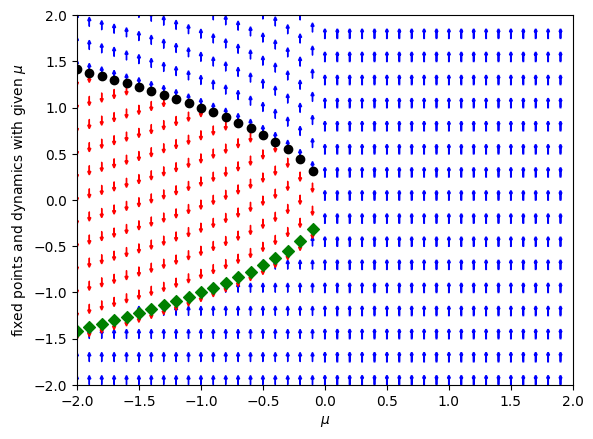

In [11]:
saddle_points0 = np.array([])
saddle_points1 = np.array([])

stepsize = 0.1
for mu in np.arange(-2, 2, stepsize):
    a = xdot(mu = mu, x = t)
    zero_crossings = np.where(np.diff(np.signbit(a)))[0]
    if zero_crossings.size > 1:
        saddle_points0 = np.append(saddle_points0, t[zero_crossings[0]])
        saddle_points1 = np.append(saddle_points1, t[zero_crossings[1]])
        for arrows in np.arange(-5,t[zero_crossings[0]],0.25):
            plt.arrow(mu, arrows, 0.0, 0.1,shape='full', lw=1, length_includes_head=True, head_width=.025, color ="blue")
        for arrows in np.arange(t[zero_crossings[0]], t[zero_crossings[1]],0.25):
            plt.arrow(mu, arrows, 0.0, -0.1,shape='full', lw=1, length_includes_head=True, head_width=.025, color ="red")
        for arrows in np.arange(t[zero_crossings[1]],2,0.25):
            plt.arrow(mu, arrows, 0.0, 0.1,shape='full', lw=1, length_includes_head=True, head_width=.025, color ="blue")


    elif zero_crossings.size == 1:
        saddle_points0 = np.append(saddle_points0, t[zero_crossings])
        saddle_points1 = np.append(saddle_points0, np.nan)
    else:
        saddle_points0 = np.append(saddle_points0, np.nan)
        saddle_points1 = np.append(saddle_points1, np.nan) 
        
        for arrows in np.arange(-2,2,0.25):
            plt.arrow(mu, arrows, 0.0, 0.1, lw=1.3, length_includes_head=True, head_width=.02, color ="blue")
    
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.scatter(np.arange(-2,2,stepsize), saddle_points0, color="green", marker='D')
plt.scatter(np.arange(-2,2,stepsize), saddle_points1, color="black", marker='o')
plt.ylabel("fixed points and dynamics with given $\mu$")
plt.xlabel("$\mu$")



We see that at the **critical value** $\mu_c = 0$ there is a **qualitative change in behaviour** in the system: for $\mu_c < 0$ there are two fixed points, whereas for $\mu_c > 0$ there are no fixed points at all.  In this particular ODE the two fixed points collide in a **saddle--node** or **fold** bifurcation.


## Bistability and hysteresis

Now let's look at the dynamics of the following system:


$$\dot{x} = \mu + x - x^3.$$



In [12]:
def h(mu, x):
    return mu + x - x**3

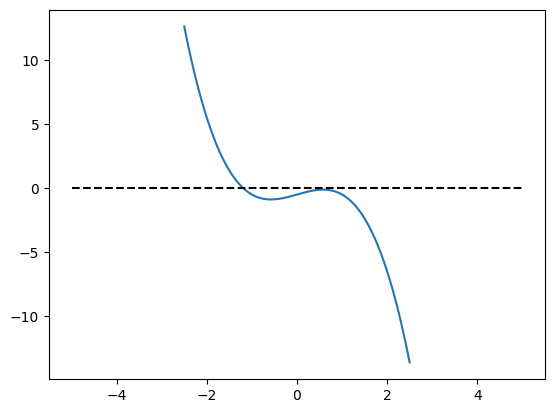

In [18]:
plt.plot(t/2, h(mu=-0.5, x=t/2))
plt.hlines(0, xmin=-5, xmax=5, color="black", ls="--")

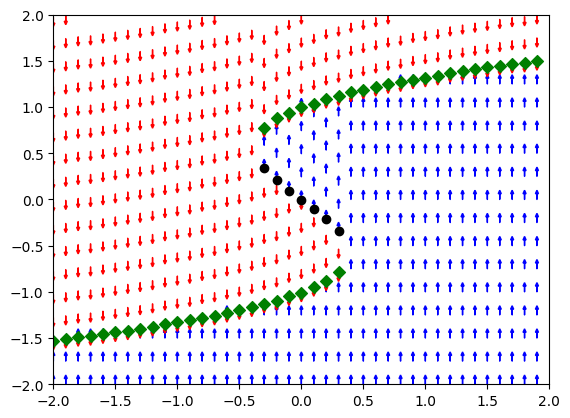

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def h(mu, x):
    return mu + x - x**3

saddle_points0 = np.array([])
saddle_points1 = np.array([])
saddle_points2 = np.array([])

t = np.linspace(-2, 2, 400)  # Ensuring enough points for precision
stepsize = 0.1
arrow_length = 0.1
arrow_head_width = 0.025
arrow_lw = 1

for mu in np.arange(-2, 2, stepsize):
    a = h(mu, t)
    zero_crossings = np.where(np.diff(np.signbit(a)))[0]
    
    if zero_crossings.size > 2:
        saddle_points0 = np.append(saddle_points0, t[zero_crossings[0]])
        saddle_points1 = np.append(saddle_points1, t[zero_crossings[1]])
        saddle_points2 = np.append(saddle_points2, t[zero_crossings[2]])

        for arrows in np.arange(-2, t[zero_crossings[0]], 0.25):
            plt.arrow(mu, arrows, 0.0, arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="blue")
        for arrows in np.arange(t[zero_crossings[0]], t[zero_crossings[1]], 0.25):
            plt.arrow(mu, arrows, 0.0, -arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="red")
        for arrows in np.arange(t[zero_crossings[1]], t[zero_crossings[2]], 0.25):
            plt.arrow(mu, arrows, 0.0, arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="blue")
        for arrows in np.arange(t[zero_crossings[2]], 2, 0.25):
            plt.arrow(mu, arrows, 0.0, -arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="red")
            
    elif zero_crossings.size == 2:
        saddle_points0 = np.append(saddle_points0, t[zero_crossings[0]])
        saddle_points1 = np.append(saddle_points1, t[zero_crossings[1]])
        saddle_points2 = np.append(saddle_points2, np.nan)
        for arrows in np.arange(-2, t[zero_crossings[0]], 0.25):
            plt.arrow(mu, arrows, 0.0, arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="blue")
        for arrows in np.arange(t[zero_crossings[0]], t[zero_crossings[1]], 0.25):
            plt.arrow(mu, arrows, 0.0, -arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="red")
        for arrows in np.arange(t[zero_crossings[1]], 2, 0.25):
            plt.arrow(mu, arrows, 0.0, arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="blue")
            
    elif zero_crossings.size == 1:
        saddle_points0 = np.append(saddle_points0, t[zero_crossings])
        saddle_points1 = np.append(saddle_points1, np.nan)
        saddle_points2 = np.append(saddle_points2, np.nan)
        
        for arrows in np.arange(-2, t[zero_crossings[0]], 0.25):
            plt.arrow(mu, arrows, 0.0, arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="blue")
        for arrows in np.arange(t[zero_crossings[0]], 2, 0.25):
            plt.arrow(mu, arrows, 0.0, -arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="red")
    else:
        saddle_points0 = np.append(saddle_points0, np.nan)
        saddle_points1 = np.append(saddle_points1, np.nan) 
        saddle_points2 = np.append(saddle_points2, np.nan) 
        
        for arrows in np.arange(-2, 2, 0.25):
            plt.arrow(mu, arrows, 0.0, arrow_length, shape='full', lw=arrow_lw, length_includes_head=True, head_width=arrow_head_width, color="blue")

plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.scatter(np.arange(-2, 2, stepsize), saddle_points0, color="green", marker='D')
plt.scatter(np.arange(-2, 2, stepsize), saddle_points1, color="black", marker='o')
plt.scatter(np.arange(-2, 2, stepsize), saddle_points2, color="green", marker='D')


We see that there is a range of values of $\mu$ for which there are *three coexisting fixed points*, two stable and one unstable. Since there are two stable fixed points in which the system can remain, we say that the system is **bistable**.


Now that we understand what the plots mean and the dynamics, let's plot just the fixed points $x^*(\mu)$ as a function of $\mu$. Such a plot is called a **bifurcation diagram**:

The pieces of curve are called **branches**.



## Hysteresis



Suppose we now think about slowly varying the parameter $\mu$. If we change the parameter $\mu$ by a little, the system is no longer at a fixed point, since the position of the fixed point moves when $\mu$ changes. However, the system will then **relax** by following the dynamics at the new value of $\mu$, and will rapidly converge to the new fixed point nearby.
For example, starting at $\mu=-2$, the system will stay on the lower black (stable) **branch** until $\mu=0.4$ or so. At that point, two fixed points collide and annihilate each other! After that there is no longer a fixed point nearby. However, there is another fixed point much further up that will now attract all trajectories, so the system rapidly transitions to that fixed point.
Now suppose we decrease the parameter again. The system will now track the *upper* branch until $\mu=-0.4$ or so, when again it will jump back down.
For each parameter value $\mu$ in the interval $[-0.4, 0.4]$ there is **bistability**, i.e. **coexistence** of *two* fixed points with the same value of $\mu$ (together with a third, unstable fixed point that is not observable).
The fact that the system tracks different stable branches depending on where we started, i.e. on the history, is known as **hysteresis**.


Hysteretic behaviour like this is found in many scientific and engineering contexts, including switches in biology, for example genetic switches, and in the historical dynamics of the earth's climate.



## Slow--fast systems

What are we actually doing when we let the parameter $\mu$ vary? Effectively we now have a system with *two* equations, for example

$$\dot{x} = \mu + x - x^3;$$
$$\dot{\mu} = \epsilon,$$

where $\mu$ varies at some slow speed $\epsilon$. On a time scale much shorter than $1 / \epsilon$, the dynamics of $x$ "does not know" that $\mu$ is changing, so it will converge to a fixed point $x^*(\mu)$ for the current value of $\mu$. [An associated term is **adiabatic approximation**.] However, $\mu$ does gradually change, so the value of $x$ will effectively "slide along" the curve $x(t) \simeq x^*(\mu(t))$, tracking the curve of fixed points as $\mu$ changes.
Once $\mu$ reaches a critical value $\mu_c$, however, there is no longer a nearby fixed point, and the dynamics will rapidly transition to the far away alternative fixed point.
If we now reverse the dynamics of $\mu$, we slide back along the upper branch.
"""

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

def brusselator(A, B, X, Y):
    dxdt = A - (B + 1) * X + X**2 * Y
    dydt = B * X - X**2 * Y
    return dxdt, dydt

@interact
def interactive_brusselator(A=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1),
                            B=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1)):
    X = np.linspace(-2, 2, 20)
    Y = np.linspace(-2, 2, 20)

    X, Y = np.meshgrid(X, Y)
    U, V = brusselator(A, B, X, Y)

    speed = np.sqrt(U**2 + V**2)

    fig, ax = plt.subplots(figsize=(8, 8))
    strm = ax.streamplot(X, Y, U, V, density=1.5, color=speed, cmap='viridis', linewidth=1.5, norm=Normalize(vmin=speed.min(), vmax=speed.max()))
    cbar = fig.colorbar(strm.lines)
    cbar.set_label('Speed')

    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Brusselator Model Phase Portrait\n(A={}, B={})'.format(A, B))
    plt.grid(True)
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='A', max=5.0, min=0.1), FloatSlider(value=1.0, descri…

# 3D: Chaos in the Lorenz equations

The [Lorenz equations](https://en.wikipedia.org/wiki/Lorenz_system) is a (very) simplified model of convection in a layer of fluid representing the atmosphere, first investigated in a famous paper by Edward Lorenz, published in 1963, about work done at MIT.  They represent a pioneering numerical investigation of **chaotic behaviour**.

The Lorenz equations are a set of three coupled ODEs. They have an apparently simple form, with only two nonlinear terms:

$$\begin{align}
\dot{x} &= \sigma (y - x) \\[6pt]
\dot{y} &= x (\rho - z) - y \\[6pt]
\dot{z} &= x y - \beta z
\end{align}$$

In [21]:
# Parameters
sigma = 10.0
beta = 8.0 / 3.0

# Lorenz equations
def lorenz(t, state, rho):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

@interact
def interactive_lorenz(rho=widgets.FloatSlider(value=1.0, min=0.0, max=50.0, step=0.1, description='Rho:')):
    # Initial conditions and time span
    initial_state = [0.0, 1.0, 0.0]
    t_span = (0, 50)
    t_eval = np.linspace(*t_span, 5000)
    sol = solve_ivp(lorenz, t_span, initial_state, args=(rho,), t_eval=t_eval)
    x, y, z = sol.y
    # Create a 3D plot
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=15, azim=80)  # elev=90 makes Z vertical, azim=0 sets the view angle
    
    ax.clear()
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Lorenz Attractor (Rho={rho})')
    plt.draw()

interactive(children=(FloatSlider(value=1.0, description='Rho:', max=50.0), Output()), _dom_classes=('widget-i…

Deterministic chaos occurs when nearby initial conditions separate exponentially fast in state space. This has been given the name **butterfly effect**: the perturbation to the atmosphere's state caused by a butterfly flapping its wings could end up being magnified to modify the direction in which a tornado moves. 

We can see this in a simple way by perturbing the initial condition slightly and calculating the distance between the two systems as a function of $t$:

In [23]:
initial_state = (0.01, 0.01, 0.01)
epsilon = 1e-10
peturbed_state = (0.01+epsilon, 0.01+epsilon, 0.01+epsilon)

# Parameters
sigma = 10.0
beta = 8.0 / 3.0
rho = 28.

In [24]:
t_span = (0, 50)
t_eval = np.linspace(*t_span, 50000)

solution1 = solve_ivp(lorenz, t_span, initial_state, args=(rho,), t_eval=t_eval)
solution2 = solve_ivp(lorenz, t_span, peturbed_state, args=(rho,), t_eval=t_eval)

distances = np.sqrt(np.sum((solution2.y - solution1.y)**2, axis=0))

Text(0, 0.5, 'Distance between two initial conditions')

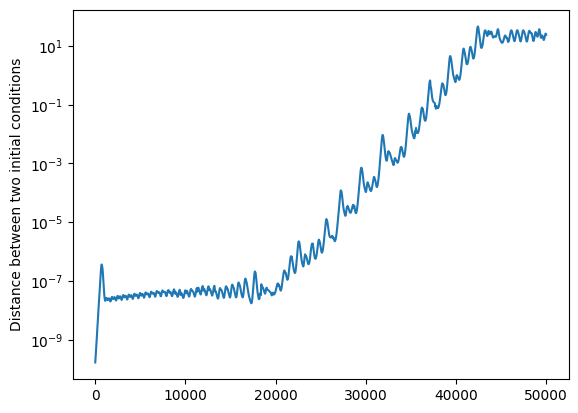

In [25]:
plt.semilogy(distances)
plt.ylabel("Distance between two initial conditions")

We indeed see a significant window over which the distance grows exponentially (straight line on the semi-logarithmic graph) for large enough values of $\rho$, before it saturates at a value of the order of the diameter of the attractor. 

Since the Lorenz equations model the atmosphere, we could expect that the dynamics of the atmosphere are at least as complicated.

We can also plot the $x$ coordinate of each trajectory for comparison:


Text(0.5, 0, 't')

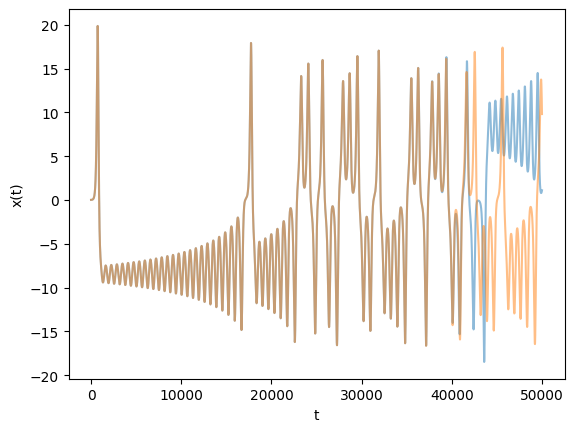

In [26]:
plt.plot(solution2.y[0], alpha=0.5)
plt.plot(solution1.y[0], alpha=0.5)
plt.ylabel("x(t)")
plt.xlabel("t")

```{important}
Now let's look at the "climate" in this model, namely the average value of each coordinate over a long time.
```

In [27]:
t_span = (0, 1000)
t_eval = np.linspace(*t_span, 5000)

solution3 = solve_ivp(lorenz, t_span, initial_state, args=(rho,), t_eval=t_eval)
solution4 = solve_ivp(lorenz, t_span, peturbed_state, args=(rho,), t_eval=t_eval)

print(np.mean(np.abs(solution3.y), axis=1))
print(np.mean(np.abs(solution4.y), axis=1))

[ 6.49853417  6.9047668  23.62573919]
[ 6.50016063  6.93978189 23.62765838]


We see that the average mean value of each component is approximately the same, even though the individual trajectories are wildly different. This is an example of how statistical properties can be the same, even if individual behaviour is very different, and motivates the idea that climate -- i.e. "average weather" -- can be stable, even if day-to-day variations differ a lot.

```{note}
Thanks a lot to [David P. Sanders](https://github.com/dpsanders) for providing the lecture. The original lecture is part of the MIT class [Introduction to Computational Thinking](https://computationalthinking.mit.edu/Fall20/lecture20/).

This class uses the [Julia programming language](http://www.julialang.org/). The orignal code can be found under [github.com](https://github.com/mitmath/18S191/blob/master/lecture_notebooks/week11/nonlinear_dynamics_bifurcations.jl)
````